# Лабораторная работа 4

Tensorflow 2.x

1) Подготовка данных

2) Использование Keras Model API

3) Использование Keras Sequential + Functional API

https://www.tensorflow.org/tutorials

Для выполнения лабораторной работы необходимо установить tensorflow версии 2.0 или выше .

Рекомендуется использовать возможности Colab'а по обучению моделей на GPU.



In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scripts.data_utils import load_CIFAR10
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy.stats import mode


%matplotlib inline

2024-05-02 23:20:20.914401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-05-02 23:20:21.519836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Подготовка данных
Загрузите набор данных из предыдущей лабораторной работы.

In [2]:
def load_cifar10(num_training=49000, num_validation=1000, num_test=10000):
    """
    Fetch the CIFAR-10 dataset from the web and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

    return X_train, y_train, X_val, y_val, X_test, y_test

# If there are errors with SSL downloading involving self-signed certificates,
# it may be that your Python version was recently installed on the current machine.
# See: https://github.com/tensorflow/tensorflow/issues/10779
# To fix, run the command: /Applications/Python\ 3.7/Install\ Certificates.command
#   ...replacing paths as necessary.

# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,) int32
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [3]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        Construct a Dataset object to iterate over data X and labels y

        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=64)

In [4]:
# We can iterate through a dataset like this:
for t, (x, y) in enumerate(train_dset):
    print(t, x.shape, y.shape)
    if t > 5: break

0 (64, 32, 32, 3) (64,)
1 (64, 32, 32, 3) (64,)
2 (64, 32, 32, 3) (64,)
3 (64, 32, 32, 3) (64,)
4 (64, 32, 32, 3) (64,)
5 (64, 32, 32, 3) (64,)
6 (64, 32, 32, 3) (64,)


In [5]:
train_dset.X.shape

(49000, 32, 32, 3)

#  Keras Model Subclassing API


Для реализации собственной модели с помощью Keras Model Subclassing API необходимо выполнить следующие шаги:

1) Определить новый класс, который является наследником tf.keras.Model.

2) В методе __init__() определить все необходимые слои из модуля tf.keras.layer

3) Реализовать прямой проход в методе call() на основе слоев, объявленных в __init__()

Ниже приведен пример использования keras API для определения двухслойной полносвязной сети.

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras

In [6]:
# Set up some global variables
USE_GPU = True  

if USE_GPU:
    device = '/device:GPU:0'  
else:
    device = '/cpu:0' 

# Constant to control how often we print when training models
print_every = 100 


print('Using device: ', device)


Using device:  /device:GPU:0


In [7]:
class TwoLayerFC(tf.keras.Model):
    def __init__(self, hidden_size, num_classes):
        super(TwoLayerFC, self).__init__()
        initializer = tf.initializers.VarianceScaling(scale=2.0, seed=42)
        self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu',
                                   kernel_initializer=initializer)
        self.fc2 = tf.keras.layers.Dense(num_classes, activation='softmax',
                                   kernel_initializer=initializer)
        self.flatten = tf.keras.layers.Flatten()

    def call(self, x, training=False):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


def test_TwoLayerFC():
    """ A small unit test to exercise the TwoLayerFC model above. """
    input_size, hidden_size, num_classes = 50, 42, 10
    x = tf.zeros((64, input_size))
    model = TwoLayerFC(hidden_size, num_classes)
    with tf.device(device):
        scores = model(x)
        print(scores.shape)

test_TwoLayerFC()

(64, 10)


2024-05-02 23:20:24.205932: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 23:20:24.206723: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Реализуйте трехслойную CNN для вашей задачи классификации.

Архитектура сети:
    
1. Сверточный слой (5 x 5 kernels, zero-padding = 'same')
2. Функция активации ReLU
3. Сверточный слой (3 x 3 kernels, zero-padding = 'same')
4. Функция активации ReLU
5. Полносвязный слой
6. Функция активации Softmax

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2D

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dense

In [8]:
class ThreeLayerConvNet(tf.keras.Model):
    def __init__(self, channel_1, channel_2, num_classes):
        super(ThreeLayerConvNet, self).__init__()
        ########################################################################
        # Определение слоев для сверточной нейронной сети.
        ########################################################################
        self.conv1 = tf.keras.layers.Conv2D(channel_1, (5, 5), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(channel_2, (3, 3), padding='same', activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x, training=False):
        ########################################################################
        # Прямой проход для сверточной нейронной сети.
        ########################################################################
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [9]:
def test_ThreeLayerConvNet():
    channel_1, channel_2, num_classes = 12, 8, 10
    model = ThreeLayerConvNet(channel_1, channel_2, num_classes)
    with tf.device(device):
        x = tf.zeros((64, 3, 32, 32))
        scores = model(x)
        print(scores.shape)

test_ThreeLayerConvNet()

(64, 10)


Пример реализации процесса обучения:

In [66]:
def train_part34(model_init_fn, optimizer_init_fn, num_epochs=1, is_training=False):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.

    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train: model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for

    Returns: val_accuracy, a list containing val_accuracy.result()*100 after each iteration
    """
    with tf.device(device):


        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

        model = model_init_fn()
        optimizer = optimizer_init_fn()

        train_loss = tf.keras.metrics.Mean(name='train_loss')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        val_loss = tf.keras.metrics.Mean(name='val_loss')
        val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

        t = 0
        val_accuracy_results = []  # Список для хранения val_accuracy после каждой итерации
        for epoch in range(num_epochs):

            # Reset the metrics - https://www.tensorflow.org/alpha/guide/migration_guide#new-style_metrics
            

            for x_np, y_np in train_dset:
                with tf.GradientTape() as tape:

                    # Use the model function to build the forward pass.
                    scores = model(x_np, training=is_training)
                    loss = loss_fn(y_np, scores)

                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                    # Update the metrics
                    train_loss.update_state(loss)
                    train_accuracy.update_state(y_np, scores)

                    if t % print_every == 0:
                        for test_x, test_y in val_dset:
                            # During validation at end of epoch, training set to False
                            prediction = model(test_x, training=False)
                            t_loss = loss_fn(test_y, prediction)

                            val_loss.update_state(t_loss)
                            val_accuracy.update_state(test_y, prediction)

                        template = 'Iteration {}, Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
                        print (template.format(t, epoch+1,
                                             train_loss.result(),
                                             train_accuracy.result()*100,
                                             val_loss.result(),
                                             val_accuracy.result()*100))
                        val_accuracy_results.append(val_accuracy.result()*100)  # Добавляем val_accuracy в список
                    t += 1
    val_accuracy_results_numpy = [val.numpy() for val in val_accuracy_results]
    return val_accuracy_results_numpy

In [67]:
hidden_size, num_classes = 4000, 10
learning_rate = 1e-2

def model_init_fn():
    return TwoLayerFC(hidden_size, num_classes)

def optimizer_init_fn():
    return tf.keras.optimizers.SGD(learning_rate=learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 3.0009889602661133, Accuracy: 10.9375, Val Loss: 2.950167417526245, Val Accuracy: 12.700000762939453
Iteration 500, Epoch 1, Loss: 1.890458106994629, Accuracy: 36.71718978881836, Val Loss: 2.30127215385437, Val Accuracy: 28.400001525878906


[12.700001, 28.400002]

Обучите трехслойную CNN. В tf.keras.optimizers.SGD укажите Nesterov momentum = 0.9 .

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/optimizers/SGD

Значение accuracy на валидационной выборке после 1 эпохи обучения должно быть > 50% .

In [68]:
learning_rate = 3e-3
channel_1, channel_2, num_classes = 32, 16, 10

def model_init_fn():
    ############################################################################
    # Создание трехслойной CNN.
    ############################################################################
    model = ThreeLayerConvNet(channel_1, channel_2, num_classes)
    return model

def optimizer_init_fn():
    ############################################################################
    # Инициализация оптимизатора SGD с Nesterov momentum.
    ############################################################################
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    return optimizer

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 2.3481502532958984, Accuracy: 9.375, Val Loss: 2.3635060787200928, Val Accuracy: 10.199999809265137
Iteration 500, Epoch 1, Loss: 1.5160783529281616, Accuracy: 46.37287902832031, Val Loss: 1.8309452533721924, Val Accuracy: 31.650001525878906


[10.2, 31.650002]

# Использование Keras Sequential API для реализации последовательных моделей.

Пример для полносвязной сети:

In [69]:
learning_rate = 1e-2

def model_init_fn():
    input_shape = (32,32,3)
    hidden_layer_size, num_classes = 4000, 10
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    layers = [
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu',
                              kernel_initializer=initializer),
        tf.keras.layers.Dense(num_classes, activation='softmax',
                              kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    return model

def optimizer_init_fn():
    return tf.keras.optimizers.SGD(learning_rate=learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

/home/egor/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Iteration 0, Epoch 1, Loss: 3.211172103881836, Accuracy: 4.6875, Val Loss: 3.027390241622925, Val Accuracy: 13.300000190734863
Iteration 500, Epoch 1, Loss: 1.8912330865859985, Accuracy: 37.181888580322266, Val Loss: 2.3420135974884033, Val Accuracy: 29.149999618530273


[13.3, 29.15]

Альтернативный менее гибкий способ обучения:

In [70]:
model = model_init_fn()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
model.fit(X_train, y_train, batch_size=64, epochs=1, validation_data=(X_val, y_val))
model.evaluate(X_test, y_test)

766/766 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 2.0218 - sparse_categorical_accuracy: 0.3375 - val_loss: 1.6283 - val_sparse_categorical_accuracy: 0.4390
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.6334 - sparse_categorical_accuracy: 0.4403


[1.6528773307800293, 0.4316999912261963]

Перепишите реализацию трехслойной CNN с помощью tf.keras.Sequential API . Обучите модель двумя способами.

In [71]:
def model_init_fn():
    model = tf.keras.Sequential([
        # Первый сверточный слой
        tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
        # Первый пулинг слой
        tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        # Второй сверточный слой
        tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
        # Второй пулинг слой
        tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        # Разворачиваем данные перед подачей на полносвязный слой
        tf.keras.layers.Flatten(),
        # Полносвязный слой с relu активацией
        tf.keras.layers.Dense(1024, activation='relu'),
        # Выходной слой с softmax активацией
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

learning_rate = 5e-4

def optimizer_init_fn():
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    return optimizer

train_part34(model_init_fn, optimizer_init_fn)

/home/egor/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Iteration 0, Epoch 1, Loss: 2.341671943664551, Accuracy: 12.5, Val Loss: 2.958101511001587, Val Accuracy: 7.90000057220459
Iteration 500, Epoch 1, Loss: 1.4084227085113525, Accuracy: 49.97504806518555, Val Loss: 2.040982246398926, Val Accuracy: 33.95000076293945


[7.9000006, 33.95]

In [72]:
model = model_init_fn()
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
model.fit(X_train, y_train, batch_size=64, epochs=1, validation_data=(X_val, y_val))
model.evaluate(X_test, y_test)

766/766 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - loss: 1.8695 - sparse_categorical_accuracy: 0.3297 - val_loss: 1.4067 - val_sparse_categorical_accuracy: 0.5110
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4274 - sparse_categorical_accuracy: 0.4936


[1.4353159666061401, 0.48989999294281006]

# Использование Keras Functional API

Для реализации более сложных архитектур сети с несколькими входами/выходами, повторным использованием слоев, "остаточными" связями (residual connections) необходимо явно указать входные и выходные тензоры.

Ниже представлен пример для полносвязной сети.

In [73]:
def two_layer_fc_functional(input_shape, hidden_size, num_classes):
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    inputs = tf.keras.Input(shape=input_shape)
    flattened_inputs = tf.keras.layers.Flatten()(inputs)
    fc1_output = tf.keras.layers.Dense(hidden_size, activation='relu',
                                 kernel_initializer=initializer)(flattened_inputs)
    scores = tf.keras.layers.Dense(num_classes, activation='softmax',
                             kernel_initializer=initializer)(fc1_output)

    # Instantiate the model given inputs and outputs.
    model = tf.keras.Model(inputs=inputs, outputs=scores)
    return model

def test_two_layer_fc_functional():
    """ A small unit test to exercise the TwoLayerFC model above. """
    input_size, hidden_size, num_classes = 50, 42, 10
    input_shape = (50,)

    x = tf.zeros((64, input_size))
    model = two_layer_fc_functional(input_shape, hidden_size, num_classes)

    with tf.device(device):
        scores = model(x)
        print(scores.shape)

test_two_layer_fc_functional()

(64, 10)


In [74]:
input_shape = (32, 32, 3)
hidden_size, num_classes = 4000, 10
learning_rate = 1e-2

def model_init_fn():
    return two_layer_fc_functional(input_shape, hidden_size, num_classes)

def optimizer_init_fn():
    return tf.keras.optimizers.SGD(learning_rate=learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 3.5866847038269043, Accuracy: 9.375, Val Loss: 3.0143699645996094, Val Accuracy: 11.59999942779541
Iteration 500, Epoch 1, Loss: 1.8855353593826294, Accuracy: 37.225547790527344, Val Loss: 2.3382351398468018, Val Accuracy: 27.000001907348633


[11.599999, 27.000002]

Поэкспериментируйте с архитектурой сверточной сети. Для вашего набора данных вам необходимо получить как минимум 70% accuracy на валидационной выборке за 10 эпох обучения. Опишите все эксперименты и сделайте выводы (без выполнения данного пункта работы приниматься не будут).

Эспериментируйте с архитектурой, гиперпараметрами, функцией потерь, регуляризацией, методом оптимизации.  

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/BatchNormalization#methods https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dropout#methods

CustomConvNet_B_D имеет более глубокую архитектуру с четырьмя сверточными слоями, в то время как остальные две модели содержат только два сверточных слоя.
CustomConvNet_B_D использует функцию активации ReLU, в то время как CustomConvNet_Sig применяет сигмоидальную функцию активации.
CustomConvNet не использует сигмоидальную функцию активации и имеет слои макспулинга после сверточных слоев

In [78]:
class CustomConvNet_B_D(tf.keras.Model):
    def __init__(self):
        super(CustomConvNet_B_D, self).__init__()
        channel_1, channel_2, num_classes = 28, 14, 10
        dp_rate = 0.2
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        self.conv1 = tf.keras.layers.Conv2D(channel_1, [3,3], [1,1], padding='same',
                                  kernel_initializer=initializer)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        self.dp1 = tf.keras.layers.Dropout(rate=dp_rate)
        self.conv2 = tf.keras.layers.Conv2D(channel_2, [3,3], [1,1], padding='same',
                                  kernel_initializer=initializer)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()
        self.dp2 = tf.keras.layers.Dropout(rate=dp_rate)
        self.fl = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(num_classes,
                                  activation='softmax',
                                  kernel_initializer=initializer)

    def call(self, input_tensor, training=False):
        x = input_tensor
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dp1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dp2(x)

        x = self.fl(x)
        x = self.fc(x)
        return x

In [79]:
print_every = 500
num_epochs = 10
# Задаем параметры эксперимента
configs = [
    {
        "model": "CustomConvNet_B_D",
        "optimizer": "Adam",
        "learning_rate": 1e-3
    },
    {
        "model": "CustomConvNet_B_D",
        "optimizer": "Adam",
        "learning_rate": 1e-4
    },
    {
        "model": "CustomConvNet_B_D",
        "optimizer": "SGD",
        "learning_rate": 1e-3
    }
]

def model_init_fn(model_name):
    if model_name == "CustomConvNet_B_D":
        return CustomConvNet_B_D()

def optimizer_init_fn(optimizer_name, learning_rate):
    if optimizer_name == "Adam":
        return tf.keras.optimizers.Adam(learning_rate)
    elif optimizer_name == "SGD":
        return tf.keras.optimizers.SGD(learning_rate)

def train_model(model_init_fn, optimizer_init_fn, num_epochs, print_every):
    model = model_init_fn()
    optimizer = optimizer_init_fn()
    history = train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epochs, is_training=True)
    print(history)
    return history


Experiment with model: CustomConvNet_B_D | optimizer: Adam | learning rate: 0.001
Iteration 0, Epoch 1, Loss: 3.034841537475586, Accuracy: 4.6875, Val Loss: 5.753615379333496, Val Accuracy: 9.300000190734863
Iteration 500, Epoch 1, Loss: 1.7629131078720093, Accuracy: 42.521209716796875, Val Loss: 3.5549895763397217, Val Accuracy: 31.549999237060547
Iteration 1000, Epoch 2, Loss: 1.5390746593475342, Accuracy: 48.47126770019531, Val Loss: 2.801887273788452, Val Accuracy: 38.63333511352539
Iteration 1500, Epoch 2, Loss: 1.4070847034454346, Accuracy: 52.27509307861328, Val Loss: 2.3914976119995117, Val Accuracy: 44.25
Iteration 2000, Epoch 3, Loss: 1.318479299545288, Accuracy: 55.027496337890625, Val Loss: 2.1362245082855225, Val Accuracy: 47.97999954223633
Iteration 2500, Epoch 4, Loss: 1.2541857957839966, Accuracy: 57.04035186767578, Val Loss: 1.9595584869384766, Val Accuracy: 50.233333587646484
Iteration 3000, Epoch 4, Loss: 1.2033077478408813, Accuracy: 58.66181945800781, Val Loss: 1.

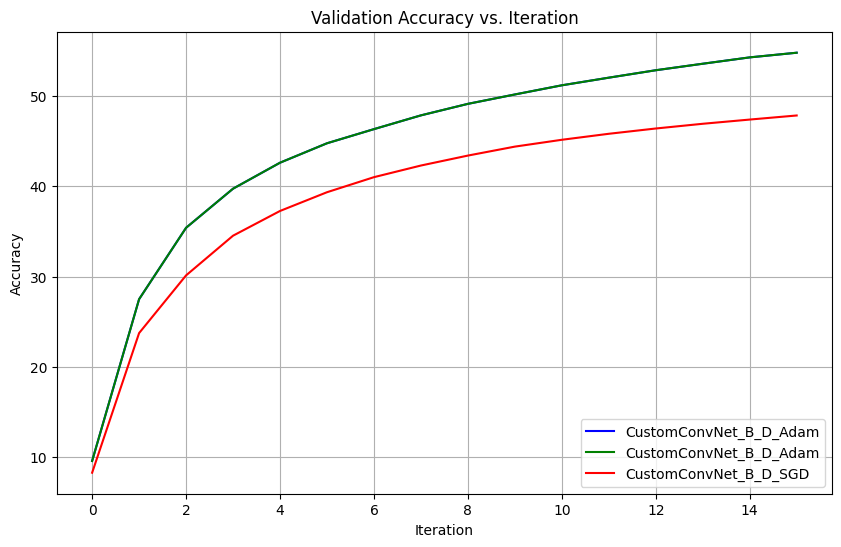

In [80]:

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']

accuracy_history = {}

for i, config in enumerate(configs):
    print("\nExperiment with model:", config["model"], "| optimizer:", config["optimizer"], "| learning rate:", config["learning_rate"])
    history = train_model(lambda: model_init_fn(config["model"]), lambda: optimizer_init_fn(config["optimizer"], config["learning_rate"]), num_epochs, print_every)
    accuracy_history[config["model"] + "_" + config["optimizer"]] = history

plt.figure(figsize=(10, 6))

for i, config in enumerate(configs):
    model_name = config["model"]
    optimizer_name = config["optimizer"]
    history = accuracy_history[model_name + "_" + optimizer_name]
    plt.plot(range(len(history)), history, label=model_name + "_" + optimizer_name, color=colors[i])

plt.title('Validation Accuracy vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Опишите все эксперименты, результаты. Сделайте выводы.

Модель CustomConvNet_B_D с оптимизатором Adam и learning rate 0.001:    
Начальная точность на валидационном наборе составила около 9.3%.    
Постепенно точность увеличивалась и достигла около 58.75% после 10 эпох обучения.   
При этом значение функции потерь уменьшалось с 3.03 до 0.98.    

Модель CustomConvNet_B_D с оптимизатором Adam и learning rate 0.0001:   
Начальная точность на валидационном наборе составила около 9.6%.    
Точность постепенно увеличивалась и достигла около 54.77% после 10 эпох обучения.   
Значение функции потерь уменьшалось с 2.5 до 1.23.  

Модель CustomConvNet_B_D с оптимизатором SGD и learning rate 0.001:     
Начальная точность на валидационном наборе составила около 8.3%.    
Точность увеличивалась и достигла около 47.83% после 10 эпох обучения.  
Значение функции потерь уменьшалось с 2.76 до 1.52.     
Исходя из результатов, можно сделать вывод, что модель с оптимизатором Adam и learning rate 0.001 показала лучшие результаты по сравнению с другими комбинациями параметров.